# Signal echoing

Echoing signal `n` steps is an example of synchronized many-to-many task.

In [1]:
from sequential_tasks import EchoData
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# By taking away these seeds, we see that even performance here is very stochastic.

# torch.manual_seed(1)
# np.random.seed(3)

In [2]:
batch_size = 5
echo_step = 3
series_length = 20_000
BPTT_T = 20

# EchoData provides input and target data for training a network to
# echo a `series_length`-long stream of data. `.x_batch` contains the input series,
# it has shape `[batch_size, series_length]`; `.y_batch` contains the target data,
# it has the same shape as `.x_batch`.
#
# Unlike other training data in this course, successive batches from a single `EchoData`
# object draw from the same stream. For example, in 08-seq_classification, training data
# has the following format:
#
#   [[S11 S12...S1N], [S21 S22...S2N], ..., [SM1 SM2...SMN]]
#
# where `SIJ` represents the `j`th sample drawn from the `i`th stream. 
#
# However, `EchoData` output has the following format (slicing along the batch dimension):
#
#   [[S11 S21...S1N], [S1(N+1) S1(N+2)...S2(2N)], ..., [S1(MN) S1(MN+1)...SM(MNN)]]
#
# This means that successive batches of data drawn from the same `EchoData` object
# are not independent.
train_data = EchoData(
    echo_step=echo_step,
    batch_size=batch_size,
    series_length=series_length,
    truncated_length=BPTT_T
)
total_values_in_one_chunck = batch_size * BPTT_T
train_size = len(train_data)

test_data = EchoData(
    echo_step=echo_step,
    batch_size=batch_size,
    series_length=series_length,
    truncated_length=BPTT_T,
)
test_data.generate_new_series()
test_data.prepare_batches()
test_size = len(test_data)

In [3]:
# Let's print first 20 timesteps of the first sequences to see the echo data:
print('(1st input sequence)  x:', *train_data.x_batch[0, :20], '... ')
print('(1st target sequence) y:', *train_data.y_batch[0, :20], '... ')

print('(1st input sequence)  x:', *test_data.x_batch[0, :20], '... ')
print('(1st target sequence) y:', *test_data.y_batch[0, :20], '... ')

(1st input sequence)  x: 1 1 1 1 1 0 1 1 1 1 1 1 0 0 1 0 1 1 0 0 ... 
(1st target sequence) y: 0 0 0 1 1 1 1 1 0 1 1 1 1 1 1 0 0 1 0 1 ... 
(1st input sequence)  x: 0 0 1 1 1 1 0 1 1 0 0 0 1 0 0 0 0 1 0 0 ... 
(1st target sequence) y: 0 0 0 0 0 1 1 1 1 0 1 1 0 0 0 1 0 0 0 0 ... 


In [4]:
# batch_size different sequences are created:
print('x_batch:', *(str(d)[1:-1] + ' ...' for d in train_data.x_batch[:, :20]), sep='\n')
print('x_batch size:', train_data.x_batch.shape)
print()
print('y_batch:', *(str(d)[1:-1] + ' ...' for d in train_data.y_batch[:, :20]), sep='\n')
print('y_batch size:', train_data.y_batch.shape)

x_batch:
1 1 1 1 1 0 1 1 1 1 1 1 0 0 1 0 1 1 0 0 ...
1 0 1 1 0 0 0 0 1 0 1 0 0 1 1 0 1 0 0 1 ...
0 0 1 0 0 1 1 1 1 0 1 1 1 0 0 1 1 0 0 0 ...
0 1 0 0 1 0 1 1 1 0 1 1 1 0 1 1 1 0 1 0 ...
1 1 0 0 0 0 1 1 0 1 1 0 1 0 1 1 0 1 1 0 ...
x_batch size: (5, 20000)

y_batch:
0 0 0 1 1 1 1 1 0 1 1 1 1 1 1 0 0 1 0 1 ...
0 0 0 1 0 1 1 0 0 0 0 1 0 1 0 0 1 1 0 1 ...
0 0 0 0 0 1 0 0 1 1 1 1 0 1 1 1 0 0 1 1 ...
0 0 0 0 1 0 0 1 0 1 1 1 0 1 1 1 0 1 1 1 ...
0 0 0 1 1 0 0 0 0 1 1 0 1 1 0 1 0 1 1 0 ...
y_batch size: (5, 20000)


In [5]:
# In order to use RNNs data is organized into temporal
# chunks of size [batch_size, T, feature_dim]
print('x_chunk:', *train_data.x_chunks[0].squeeze(), sep='\n')
print('1st x_chunk size:', train_data.x_chunks[0].shape)
print()
print('y_chunk:', *train_data.y_chunks[0].squeeze(), sep='\n')
print('1st y_chunk size:', train_data.y_chunks[0].shape)

x_chunk:
[1 1 1 1 1 0 1 1 1 1 1 1 0 0 1 0 1 1 0 0]
[1 0 1 1 0 0 0 0 1 0 1 0 0 1 1 0 1 0 0 1]
[0 0 1 0 0 1 1 1 1 0 1 1 1 0 0 1 1 0 0 0]
[0 1 0 0 1 0 1 1 1 0 1 1 1 0 1 1 1 0 1 0]
[1 1 0 0 0 0 1 1 0 1 1 0 1 0 1 1 0 1 1 0]
1st x_chunk size: (5, 20, 1)

y_chunk:
[0 0 0 1 1 1 1 1 0 1 1 1 1 1 1 0 0 1 0 1]
[0 0 0 1 0 1 1 0 0 0 0 1 0 1 0 0 1 1 0 1]
[0 0 0 0 0 1 0 0 1 1 1 1 0 1 1 1 0 0 1 1]
[0 0 0 0 1 0 0 1 0 1 1 1 0 1 1 1 0 1 1 1]
[0 0 0 1 1 0 0 0 0 1 1 0 1 1 0 1 0 1 1 0]
1st y_chunk size: (5, 20, 1)


In [6]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size, rnn_hidden_size, output_size):
        super().__init__()
        self.rnn_hidden_size = rnn_hidden_size
        self.rnn = torch.nn.RNN( # This generates a series of encodings
            input_size=input_size,
            hidden_size=rnn_hidden_size,
            num_layers=1, # Deep RNNs have a stack of hidden representations.
            nonlinearity='relu', # Also, why isn't there a weighting on the losses,
            # Such that the losses from later rounds are weighed more than
            # earlier ones, because some sequences start without any context, and
            # this just creates noise.
            batch_first=True
        )
        self.linear = torch.nn.Linear( # This is the decoder
            in_features=rnn_hidden_size,
            out_features=output_size
        )

    def forward(self, x, hidden):
        # In order to model the fact that successive batches belong to the same stream of data,
        # we share the hidden state across successive invocations.
        rnn_out, hidden = self.rnn(x, hidden)  
        if self.training:
            rnn_out.retain_grad()
        out = self.linear(rnn_out)
        return out, hidden, rnn_out

In [7]:
m = SimpleRNN(
    input_size=1,
    rnn_hidden_size=4,
    output_size=1
)

with torch.no_grad():
    for name, param in m.named_parameters():
        print(name, param.shape)
# Corresponds to ReLU(W_ih x_t + W_hh h_t-1 + b_ih + b_hh)
# And there are two biases just for compatibility with LSTM/GRU

# For the linear weights, the gradient computation is straightforward
# There is no problem with optimization there

rnn.weight_ih_l0 torch.Size([4, 1])
rnn.weight_hh_l0 torch.Size([4, 4])
rnn.bias_ih_l0 torch.Size([4])
rnn.bias_hh_l0 torch.Size([4])
linear.weight torch.Size([1, 4])
linear.bias torch.Size([1])


In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
def train():
    model.train()
    
    # New epoch --> fresh hidden state
    hidden = None   
    correct = 0
    for batch_idx in range(train_size):
        data, target = train_data[batch_idx]
        data, target = torch.from_numpy(data).float().to(device), torch.from_numpy(target).float().to(device)
        optimizer.zero_grad()
        if hidden is not None: hidden.detach_()
        logits, hidden, _ = model(data, hidden)

        # RNN has a bijection between 
        # print(data.shape, target.shape)

        loss = criterion(logits, target) # It doesn't do anything really special
        # It just has a 1-1 mapping between data and target, all at once.
        # And then it later on does a topological sort, rooted at loss.
        loss.backward() # Calculates all gradients involved (anything that has autograd=True)
        # And adds the grad dL/dw_i
        optimizer.step() # This just steps all of those things, but carefully (i.e. following
        # a stepping algorithm, like AdamW)

        
        pred = (torch.sigmoid(logits) > 0.5)
        correct += (pred == target.byte()).int().sum().item()/total_values_in_one_chunck
        
    return correct, loss.item()

In [10]:
def test():
    model.eval()   
    correct = 0
    # New epoch --> fresh hidden state
    hidden = None
    with torch.no_grad():
        for batch_idx in range(test_size):
            data, target = test_data[batch_idx]
            data, target = torch.from_numpy(data).float().to(device), torch.from_numpy(target).float().to(device)
            logits, hidden, _ = model(data, hidden)
            
            pred = (torch.sigmoid(logits) > 0.5)
            correct += (pred == target.byte()).int().sum().item()/total_values_in_one_chunck

    return correct

In [11]:
feature_dim = 1 #since we have a scalar series
h_units = 4

model = SimpleRNN(
    input_size=1,
    rnn_hidden_size=h_units,
    output_size=feature_dim
).to(device)
        
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

In [12]:
n_epochs = 5

for epoch in range(1, n_epochs+1):
    correct, loss = train()
    train_accuracy = float(correct)*100/ train_size
    print(f'Train Epoch: {epoch}/{n_epochs}, loss: {loss:.3f}, accuracy {train_accuracy:.1f}%')

#test    
correct = test()
test_accuracy = float(correct) * 100 / test_size
print(f'Test accuracy: {test_accuracy:.1f}%')

Train Epoch: 1/5, loss: 0.594, accuracy 60.0%
Train Epoch: 2/5, loss: 0.588, accuracy 65.4%
Train Epoch: 3/5, loss: 0.481, accuracy 69.0%
Train Epoch: 4/5, loss: 0.568, accuracy 69.2%
Train Epoch: 5/5, loss: 0.551, accuracy 69.1%
Test accuracy: 68.8%


In [13]:
# Let's try some echoing
my_input = torch.empty(1, 100, 1).random_(2)
hidden = None
my_out, _, _ = model(my_input.to(device), hidden)
my_pred = torch.where(my_out > .5, 
                      torch.ones_like(my_out), 
                      torch.zeros_like(my_out)).cpu()
print(my_input.view(1, -1).byte(), my_pred.view(1, -1).byte(), sep='\n')

# Calculate the expected output for our random input
expected = np.roll(my_input, echo_step)
expected[:, :echo_step] = 0
correct = expected == my_pred.numpy()
print(np.ndarray.flatten(correct))

tensor([[1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0,
         0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1,
         1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1,
         1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1,
         1, 0, 0, 1]], dtype=torch.uint8)
tensor([[1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1,
         0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0,
         1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1,
         1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
         1, 0, 1, 0]], dtype=torch.uint8)
[False False False False  True False  True False  True  True  True  True
 False False  True  True  True  True  True False  True  True  True  True
  True False  True  True False  True  True  True  True False  True  True
  True  True  True False  True  True  True  True 

In [14]:
train_size

1000

In [47]:
feature_dim = 1 #since we have a scalar series
h_units = 4

model = SimpleRNN(
    input_size=1,
    rnn_hidden_size=h_units,
    output_size=feature_dim
).to(device)
        
criterion = torch.nn.BCEWithLogitsLoss()

# optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
# optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

/var/folders/32/bzhrljpn11q6c0sjbvcy_mnc0000gq/T/ipykernel_16188/4281385684.py:55: RuntimeWarning: divide by zero encountered in log
  log_dEt_dhk_norm_avg = [np.log(x) for x in list_dEt_dhk_norm_avg]
/var/folders/32/bzhrljpn11q6c0sjbvcy_mnc0000gq/T/ipykernel_16188/4281385684.py:55: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  log_dEt_dhk_norm_avg = [np.log(x) for x in list_dEt_dhk_norm_avg]


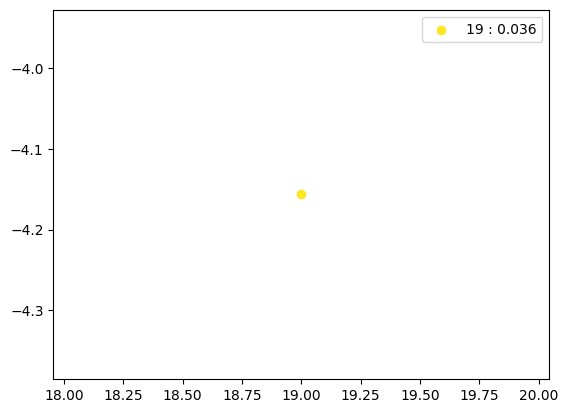

(876.5699999999989, tensor(0.1236))

In [56]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

model.train()

# New epoch --> fresh hidden state
hidden = None   
correct = 0
for batch_idx in range(train_size):
    data, target = train_data[batch_idx]
    data, target = torch.from_numpy(data).float().to(device), torch.from_numpy(target).float().to(device)
    optimizer.zero_grad()
    if hidden is not None: hidden.detach_()

    # Prediction, and tracking hidden states
    # time_steps = data.shape[1]
    logits, hidden, hidden_states = model(data, hidden)

    # print(hidden_states.shape, hidden_states)
    # print(logits.shape, logits)
    # print(hidden.shape, hidden)

    # RNN has a bijection between 
    # print(data.shape, target.shape)

    # Do this thing below, and then normalize by that, like divide every
    # gradient step by the L2 norm.
    
    seq_len = target.shape[1]

    optimizer.zero_grad()

    batch_of_interest = 100

    loss_arr = []
    prev_loss_arr = [torch.zeros((5, 20, 4))]
    for i in range(seq_len):
        if i < seq_len - 1:
            continue
        # if hidden_states.grad is not None:
        #     hidden_states.grad.zero_()

        loss_arr.append(criterion(logits[:, i:i+1, :], target[:,i:i+1,:])) # This isn't the 5 step training loop, and will yield problems if I do backward, step all inside the loop
        loss_arr[-1].backward(retain_graph=True) # need to use retain_graph because if we don't it won't remember the feedforward step we did

        with torch.no_grad():
            if batch_idx == batch_of_interest:
                dEt_dhk = hidden_states.grad - prev_loss_arr[-1] # Need to do this, because hidden_states holds the sum_{i<=t} dEi_dhk
                prev_loss_arr.append(hidden_states.grad.clone())

                dEt_dhk_norm = torch.norm(dEt_dhk, p=2, dim=-1)
                dEt_dhk_norm_avg = torch.mean(dEt_dhk_norm, dim=0)

                list_dEt_dhk_norm_avg = list(dEt_dhk_norm_avg.detach().cpu())
                log_dEt_dhk_norm_avg = [np.log(x) for x in list_dEt_dhk_norm_avg]

                cmap = cm.viridis
                if i == 0:
                    plt.figure(figsize=(20, 15))
                plt.scatter(range((dEt_dhk_norm_avg.detach().cpu().shape[0])), 
                         log_dEt_dhk_norm_avg, 
                         color=cmap(i/(seq_len-1)), 
                         label=f"{i} : {loss_arr[-1].detach().cpu().item():.3f}")
    if batch_idx == batch_of_interest:
        plt.legend()
        plt.show()

        # training time i=0 first, then stepping, then training time i=1 next, then stepping
    
    with torch.no_grad():
        loss = sum(loss_arr)/len(loss_arr)
    optimizer.step()
    
    pred = (torch.sigmoid(logits) > 0.5)
    correct += (pred == target.byte()).int().sum().item()/total_values_in_one_chunck
    
correct, loss